# Re-doing the Simplest Hydrologic Neural Net

In this notebook, we effectively repeat the development of the same neural network that we created in [this notebook](./2_SimplestNeuralNet.ipynb), but instead of coding the neural net from scratch, we use the `scikit-learn` version of a multi-perceptron classifier to fit and test a model with the same data. 

The objective is to illustrate how we get effectively the same results as in the case where we coded our own neural net (using, in fact, some of the same options), but wind up with a __much__ simpler code to implement. 

### 1. Import the Libraries
Note this time we have called to import `MLPClassifier` from scikit-learn's neural network library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

snotel_fname = 'snotel_978_bogus_basin_clean.txt'

### 2. Read in the Data

In [2]:
df = pd.read_csv(snotel_fname)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.dropna()
df.head()

,Snow Water Equivalent [mm],Accumulated Precipitation [mm],Precipitation Increment [mm],Tmax (degC),Tmin (degC),Tmean (degC),Year,DOY,Snow on Ground
Date,,,,,,,,,
1999-10-01,0.0,0.0,0.0,11.722,2.889,7.500,1999,274,0
1999-10-02,0.0,0.0,0.0,11.611,0.500,6.278,1999,275,0
1999-10-03,0.0,0.0,0.0,14.389,0.500,7.778,1999,276,0
1999-10-04,0.0,0.0,0.0,19.722,6.778,13.500,1999,277,0
1999-10-05,0.0,0.0,0.0,16.889,8.111,12.389,1999,278,0


### 3. Set Up the Data

As with the previous notebook, in the cell below we will select only the variables we need to fit and test the neural net. We will divide up the the dataset into a training and testing period. The training data goes from 10/01/1999 until 09/30/2018 (20 water years). The testing period goes from 10/01/2018 until 09/30/2023 (5 water years). 

We create a `numpy` array of the inputs for the training period and the correct observations. We do the same for the test period.  

In [3]:
data_train = df[:'2018-09-30'][['Tmean (degC)','DOY']].to_numpy()
data_train[:,0] = (data_train[:,0] - np.mean(data_train[:,0])) / np.std(data_train[:,0])
data_train[:,1] = (data_train[:,1] - np.mean(data_train[:,1])) / np.std(data_train[:,1])
data_train.shape

obs_train = df[:'2018-09-30']['Snow on Ground'].to_numpy().astype('float')
obs_train.shape

data_test = df['2018-10-01':][['Tmean (degC)','DOY']].to_numpy()
data_test[:,0] = (data_test[:,0] - np.mean(data_test[:,0])) / np.std(data_test[:,0])
data_test[:,1] = (data_test[:,1] - np.mean(data_test[:,1])) / np.std(data_test[:,1])
data_test.shape

obs_test = df['2018-10-01':]['Snow on Ground'].to_numpy().astype('float')
obs_test.shape

sog_true_test = df['2018-10-01':]['Snow on Ground'].to_numpy()

### 4. Fit the Model

We now call the `.fit()` method on `MLPClassifier` with the training data (`data_train`) and training observations/output (`obs_train`). We tell scikit learn to use the following options:

* `hidden_layer_sizes=(2,)`: 2 hidden layers (same as previous notebook)
* `activation='logistic'`: Logistic function as our activation function (same as previous notebook)
* `learning_rate_init=0.1`: Learning rate = 0.1 (same as previous notebook)
* `max_iter=1000`: iterations/epochs (same as previous notebook)
* `random_state=1`: Initialize with random weights (same as previous notebook)
* `solver='sgd'`: Use stochastic gradient descent (same as previous notebook)

Note how long it takes to fit the model:

In [4]:
%%time
clf = MLPClassifier(hidden_layer_sizes=(2,), activation='logistic',
                    learning_rate_init=0.1, random_state=1, max_iter=1000,
                    solver='sgd').fit(data_train,obs_train)


CPU times: user 244 ms, sys: 3.97 ms, total: 248 ms
Wall time: 249 ms


### 5. Evaluate the Performance

Use the trained neural network to make predictions for the test data using the `clf.predict(data_test)` function from the network. __NOTE__: a reminder that the neural network has not seen the data from from the test period. So this is a true `out-of-sample` test of our fit network. Note that `scikit-learn` provides some built-in functions to split a dataset into a train and test datasets, but we have not used them here (`scikit-learn`'s options allow for much more sophisticated ways of splitting the data).

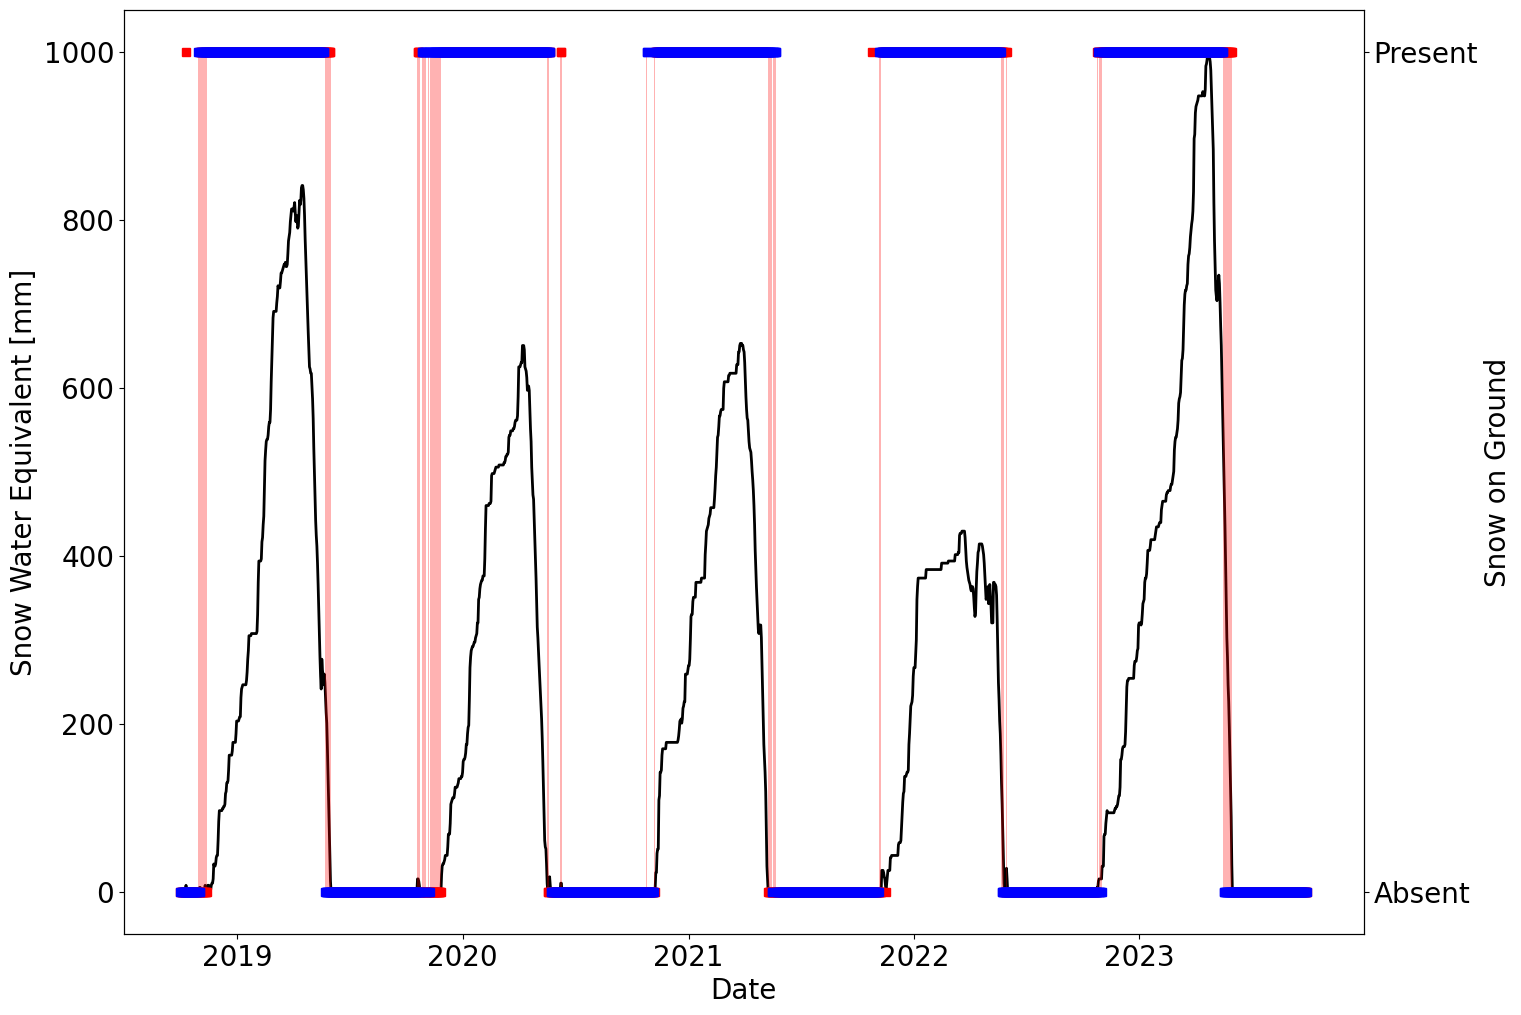

In [5]:
# Generate predictions of the presence of snow on the ground based on input from 
# the test period
sog_preds_test = clf.predict(data_test)

# Get the true values of snow presence during the test period
sog_true_test = df['2018-10-01':]['Snow on Ground'].to_numpy()

# Compute an array we can use to identify where the neural network predictions and
# observations disagree. Subtract the array containing the true condition from 
# the predicted one. Where they agree the value will be 0. Where the value is 
# different from 0, there was either a false negative or false positive condition
sog_disagree = np.where((sog_preds_test - sog_true_test)!=0,1,0)

# Create a 2-axis plot showing snow water equivalent on top of predicted and observed
# values of snow presence/absence. Highlight the times when the neural net and 
# observations do not agree
plt.rcParams.update({'font.size':20})

fig, ax1 = plt.subplots(figsize=(16,12))

ax2 = ax1.twinx()
ax2.plot(df['2018-10-01':].index,sog_true_test,'rs')
ax2.plot(df['2018-10-01':].index,sog_preds_test,'bs')
ax2.bar(df['2018-10-01':].index,sog_disagree,width=1.0,facecolor='red',alpha=0.3)
ax2.set_ylim([-0.05,1.05])
ax2.set_ylabel('Snow on Ground')
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Absent','Present'])

ax1.plot(df['2018-10-01':].index,df['2018-10-01':]['Snow Water Equivalent [mm]'],'k-',linewidth=2)
ax1.set_ylim([-50.0,1050.0])
ax1.set_ylabel('Snow Water Equivalent [mm]')
ax1.set_xlabel('Date')
plt.show()

In the above figure I have once again plotted both the observed (red squares) and predicted (blue squares) snow presence and absence. I have plotted the measured snow water equivalent (in mm) as a black line. Where the neural network based prediction and the observed snow presence/absence disagree, I have indicated with the pink vertical bars. As you can see, the disagreement between the algorithm and observation tends to occur during the shoulder seasons (fall and spring). This is perhaps unsurprising because in all likelihood day of year is a really strong predictor of snow presence/absence at any given Snotel site (and as you'll see in the weights below). Note that these patterns are largely similar to those from our scratch version of the neural net. This both gives us confidence that we did it right, and also shows us how much code we save by using some existing libraries.

Let's again show comparisons using the confusion matrix/contingency table. Similar to the previous notebook, we'll compute the number of true positives (predicted and observed snow presence), true negatives (predicted and observed snow absence), false positives (predicted unobserved snow presence), and false negatives (did not predict observed snow presence). When we compare to the previous notebook, we see that the results are very similar in terms of performance. 


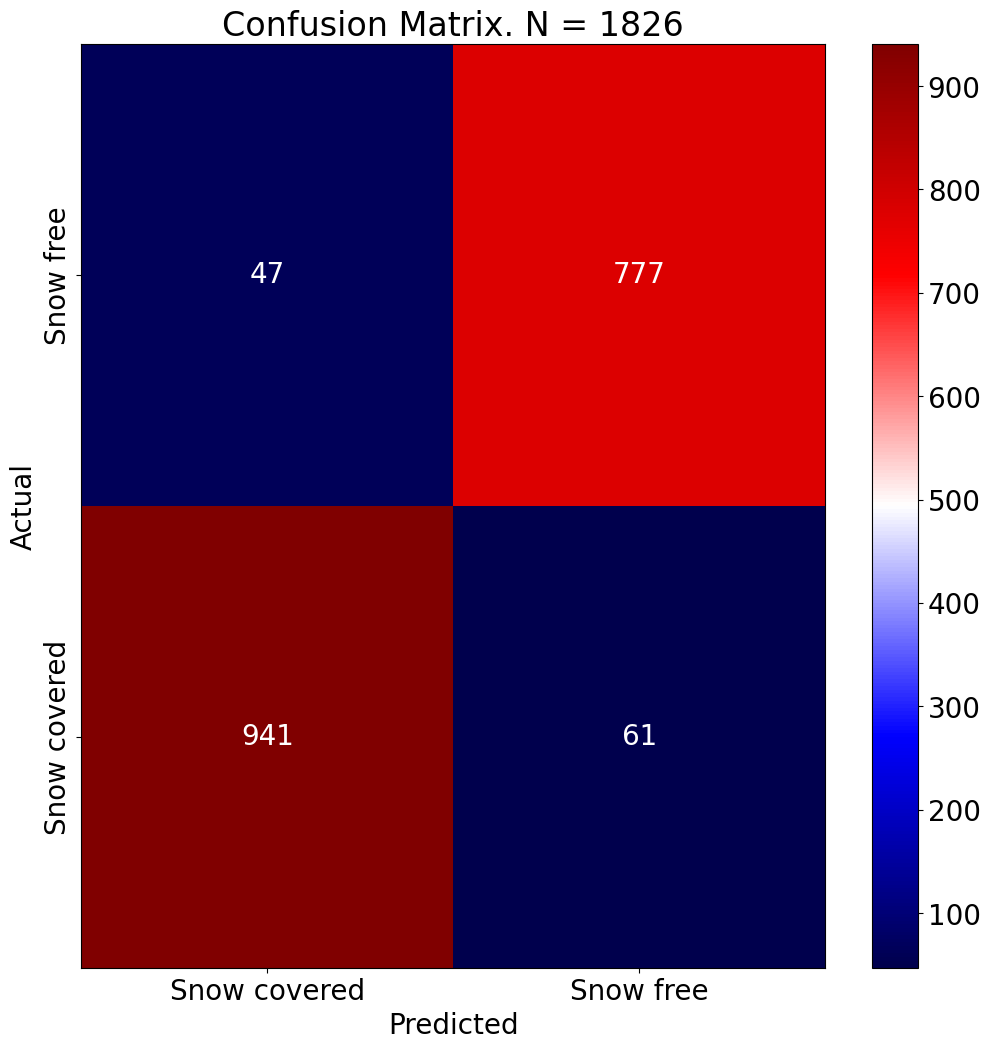

In [6]:
# Comput elements of the confusion matrix
nTruePos = np.sum(np.where((sog_preds_test==1)&(sog_true_test==1),1,0))
nTrueNeg = np.sum(np.where((sog_preds_test==0)&(sog_true_test==0),1,0))
nFalsePos = np.sum(np.where((sog_preds_test==1)&(sog_true_test==0),1,0)) 
nFalseNeg = np.sum(np.where((sog_preds_test==0)&(sog_true_test==1),1,0)) 

# Optional to convert these numbers into rates (e.g., true hit rate, true miss rate, etc.)
ConfusionMat = np.zeros((2,2))
ConfusionMat[0,0] = nTruePos #/ np.sum((sog_true==1))
ConfusionMat[0,1] = nFalseNeg #/ np.sum((sog_true==1))
ConfusionMat[1,0] = nFalsePos #/ np.sum((sog_true==0))
ConfusionMat[1,1] = nTrueNeg #/ np.sum((sog_true==0))

# Create the plot
fig = plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size':20})
plt.pcolormesh(ConfusionMat,cmap='seismic')
plt.title('Confusion Matrix. N = '+str(sog_true_test.size))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(ticks=[0.5,1.5], labels=['Snow covered','Snow free'])
plt.yticks(ticks=[0.5,1.5], labels=['Snow covered','Snow free'],rotation=90,va='center')
plt.text(0.5,0.5,'{:.0f}'.format(ConfusionMat[0,0]),ha='center',va='center',size=20,color='w')
plt.text(1.5,0.5,'{:.0f}'.format(ConfusionMat[1,0]),ha='center',va='center',size=20,color='w')
plt.text(0.5,1.5,'{:.0f}'.format(ConfusionMat[0,1]),ha='center',va='center',size=20,color='w')
plt.text(1.5,1.5,'{:.0f}'.format(ConfusionMat[1,1]),ha='center',va='center',size=20,color='w')
plt.colorbar()
plt.show()